# Active Learning with AutoEmulate

In this notebook, we'll introduce **active learning (AL)** using AutoEmulate, demonstrating how emulators and simulators work together to efficiently build accurate predictive models.

**Why Active Learning?**

High-fidelity simulators produce accurate predictions but are computationally expensive. Emulators offer fast approximations but can be unreliable, especially in unexplored regions. Active learning intelligently selects informative simulator evaluations to maximize emulator improvement with minimal computational cost.

**Key Components**

- **Simulator:** High-fidelity, reliable, expensive to run.
- **Emulator:** Fast, inexpensive surrogate model, less reliable in unseen parts of input space, but trainable.

**Active Learning Policy**

The **policy** $\mathbf{u}$ determines which input points are evaluated by the simulator. At each iteration, based on:

- **Labeled Set ($\mathcal{D}$):** Evaluated points from the simulator.
- **Query Set ($\mathcal{Q}$):** Potential points for evaluation.

The policy either:
- Selects a new point $\mathbf{x}$ for simulator evaluation, updating:
  $$
  \mathcal{D}_{i+1} = \mathcal{D}_i \cup \{(\mathbf{x}, \mathbf{y})\}, \quad \mathbf{x} = \mathbf{u}(\mathcal{D}_i, \mathcal{Q}_i).
  $$
- Or stops querying, leaving $\mathcal{D}$ unchanged:
  $$
  \mathcal{D}_{i+1} = \mathcal{D}_i, \quad \mathbf{u}(\mathcal{D}_i, \mathcal{Q}_i) = \emptyset.
  $$

**Active Learning Scenarios**

Active learning typically includes three scenarios:
1. **Stream-based AL:** Inputs arrive sequentially; the learner chooses whether to evaluate them.
2. **Pool-based AL:** A fixed pool of inputs; the learner chooses which to evaluate.
3. **Membership-based AL:** Learner generates inputs from the entire continuous input space.

**This Notebook: Stream-Based AL**

We focus on **stream-based AL**, where:

1. A user queries the emulator at specific inputs.
2. If emulator predictions are uncertain, the learner queries the simulator.
3. The emulator is retrained on simulator evaluations triggered by uncertainty.
4. The learner manages this process.

Let's implement stream-based active learning—starting with necessary imports below.


In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from typing import List, Dict, Tuple, Iterable
from dataclasses import asdict
import gpytorch

# Import core classes from the source code.
from autoemulate.experimental.learners import Emulator, Simulator, stream
from autoemulate.simulations.projectile import simulate_projectile_multioutput
from autoemulate.experimental.emulators.gaussian_process.exact import GaussianProcessExact, constant_mean, rbf
from autoemulate.experimental_design import LatinHypercube

AutoEmulate provides several experimental implementations of stream-based active learners. These learners differ in how they assess informativeness—whether based on input space, output space, or adaptive thresholds.

You can visualize the available options using:

```python
stream.Stream.plot_hierarchy()

In [2]:
stream.Stream.plot_hierarchy()

Stream [Abstract]
├── Random [Concrete]
└── Threshold [Abstract]
    ├── Input [Abstract]
    │   └── Distance [Concrete]
    ├── Output [Abstract]
    │   ├── A_Optimal [Concrete]
    │   ├── D_Optimal [Concrete]
    │   └── E_Optimal [Concrete]
    └── Adaptive [Abstract]
        ├── Adaptive_Distance [Concrete]
        ├── Adaptive_A_Optimal [Concrete]
        ├── Adaptive_D_Optimal [Concrete]
        └── Adaptive_E_Optimal [Concrete]


## Active Learning Components

To set up active learning in AutoEmulate, you typically need:

1. A **simulator** – provides ground truth data (expensive but accurate).  
2. An **emulator** – a fast surrogate that approximates the simulator.  
3. Some **initial training data** – a small set of labeled input-output pairs to start with.

### Defining Simulators

Below, we define two example simulators:

- **`Sin`**: A simple one-dimensional simulator where outputs are generated as $y = \sin(x)$.
- **`Projectile`**: A 2D simulator that maps initial velocity and drag coefficient of a projectile to its final distance and impact velocity.

In [23]:
# Define a simple sine simulator.
class Sin(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sin(X)
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(0., 50.)]).sample(n))

class Projectile(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.tensor([simulate_projectile_multioutput(x) for x in X])
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(-5., 1.), (0., 1000.)]).sample(n).astype(float))

Let's plot the Sin simulator just to get a feel.

In [4]:
simulator = Sin()
X = simulator.sample_inputs(4)
X

tensor([[21.8149],
        [ 0.3079],
        [30.7155],
        [46.0090]])

In [5]:
Y = simulator.sample(X)
Y

tensor([[ 0.1754],
        [ 0.3030],
        [-0.6446],
        [ 0.8979]])

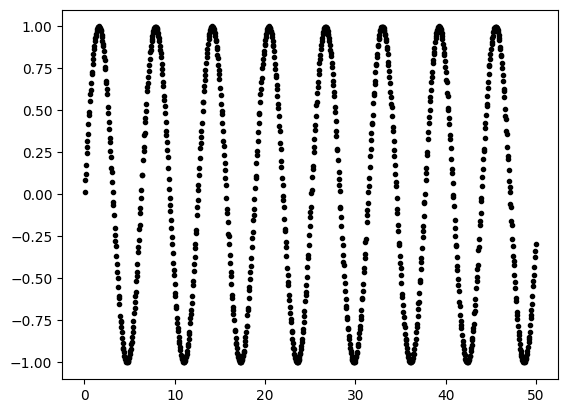

In [6]:
X = simulator.sample_inputs(1000)
Y = simulator.sample(X)
plt.scatter(X, Y, marker='.', c='k')
plt.show()

## Using the Emulator

To use an emulator in AutoEmulate, you just need to create an instance of an emulator class. The core operations are:

1. **Training** – Fit the emulator on a batch of input-output pairs.
2. **Prediction** – Generate output predictions (with uncertainty estimates) for new inputs.

In this example, we use a simple **Gaussian Process** model provided by the AutoEmulate package.

In [7]:
# Define an emulator using a dummy Gaussian Process.
from autoemulate.experimental.types import GaussianLike


class GP(Emulator):
    def __init__(self):
        self.model_cls = GaussianProcessExact
        self.model_config = {
        "likelihood_cls": gpytorch.likelihoods.MultitaskGaussianLikelihood,
        "mean_module_fn": constant_mean,
        "covar_module_fn": rbf,
    }
    def fit_forward(self, X_train, Y_train):
        self.model = self.model_cls(X, Y, **self.model_config)
        self.model.fit(X_train, Y_train)
    def sample_forward(self, X):
        output = self.model.predict(X)
        assert isinstance(output, GaussianLike)
        return output.mean

Let's get a feel for it.

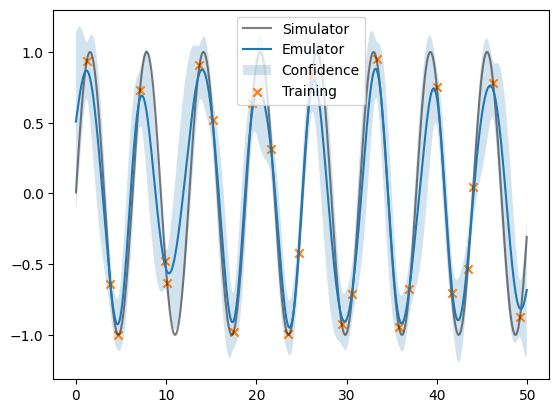

In [8]:
# Train emulator
simulator = Sin()
X_train = simulator.sample_inputs(25).sort(dim=0).values
Y_train = simulator.sample(X_train)

gp_config = {
    "likelihood_cls": gpytorch.likelihoods.MultitaskGaussianLikelihood,
    "mean_module_fn": constant_mean,
    "covar_module_fn": rbf,
    "epochs": 50,
    "batch_size": 16,
    "activation": torch.nn.ReLU,
    "lr": 2e-1,
}

emulator = GaussianProcessExact(X_train, Y_train, **gp_config)
emulator.fit(X_train, Y_train)

# Test emulator
X_test = simulator.sample_inputs(1000).sort(dim=0).values
dist = emulator.predict(X_test)
assert isinstance(dist, GaussianLike)
Y_true = simulator.sample(X_test)

# Plot
X_train, Y_train, X_test, Y_mean, Y_cov, Y_true = (
    X_train.flatten(), Y_train.flatten(), X_test.flatten(), 
    dist.mean.detach().numpy().flatten(), torch.sqrt(dist.variance).detach().numpy().flatten(), Y_true.flatten()
)
plt.plot(X_test, Y_true, label='Simulator', alpha=0.5, c='k')
plt.plot(X_test, Y_mean, label='Emulator')
plt.fill_between(X_test, Y_mean - Y_cov, Y_mean + Y_cov, alpha=0.2, label='Confidence')
plt.scatter(X_train, Y_train, label='Training', marker='x')
plt.legend()
plt.show()



The plot shows how well the emulator approximates the simulator, along with confidence intervals from the GP model. Note how the uncertainty grows in regions far from the training data!

## Using the learner

One of the simplest forms of stream-based active learning is to just sample a queried input point with some probability. Inevitably, this results in a query rate of that probability, where the query rate is the proportion of accepted input points and total input points encountered. We can instantiate and train this learner as follows.

In [9]:
# Learner components
simulator = Sin()

X_train = simulator.sample_inputs(5)
Y_train = simulator.sample(X_train)
emulator = GaussianProcessExact(X_train, Y_train, **gp_config)

# Learner itself!
learner = stream.Random(
    simulator=simulator,
    emulator=emulator,
    X_train=X_train,
    Y_train=Y_train,
    p_query=0.2
)

# Stream of 500 samples
X_stream = simulator.sample_inputs(500)
learner.fit_samples(X_stream)

Random: 100%|██████████| 500/500 [00:09<00:00, 50.33it/s, mse=0.0979, r2=0.799, rate=0.178, logdet=-10.2, trace=3.81e-5, max_eigval=3.81e-5, n_queries=89]  


In [10]:
learner.metrics.keys()

dict_keys(['mse', 'r2', 'rate', 'logdet', 'trace', 'max_eigval', 'n_queries'])

There are several metrics commonly recorded when running an active learner, each providing insight into different aspects of its performance:

1. **`mse` (Mean Squared Error)**: Measures the average squared difference between the emulator's predicted outputs and the simulator's actual outputs before updating (fitting) the emulator. A lower MSE indicates that the emulator predictions closely match the simulator.

2. **`r2` (Coefficient of Determination)**:  
   $$
   R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
   $$  
   Here, $y_{\text{true}}$ denotes the simulator outputs, $y_{\text{pred}}$ denotes the emulator's predictions, and $\bar{y}$ is the average of the simulator's outputs.

   - An $R^2$ score of **1** indicates a perfect fit—emulator predictions exactly match simulator outputs.
   - An $R^2$ score of **0** means the emulator is performing no better than a naive model that predicts the mean simulator output.
   - An $R^2$ score **less than 0** suggests the emulator predictions are worse than simply using the mean output.

3. **`rate` (Query Rate)**: The ratio of simulator queries made to the total number of input points encountered in the stream. Lower rates indicate a more efficient learner, as fewer expensive simulator queries are needed relative to the number of inputs seen.

4. **`n_queries` (Number of Queries)**: The cumulative count of how many times the simulator has been queried so far. Monitoring this number helps track the overall computational cost incurred by the learner.

5. **`logdet` (Log Determinant of Covariance)**: Represents uncertainty in the emulator’s predictions, calculated as the log determinant of the emulator’s covariance matrix. A decreasing (more negative) log determinant typically indicates increasing confidence in predictions as the emulator improves with additional simulator data.

6. **`trace` (Trace of Covariance)**: Measures the sum of variances along each dimension of the emulator's predictions, given by the trace of the covariance matrix. As the emulator learns, this metric should decrease toward zero, reflecting growing certainty.

7. **`max_eigval` (Maximum Eigenvalue of Covariance)**: Indicates the largest single uncertainty direction of the emulator’s predictions. A decreasing maximum eigenvalue approaching zero implies increased confidence in the emulator’s predictions along all directions in the output space.


Let's plot these!

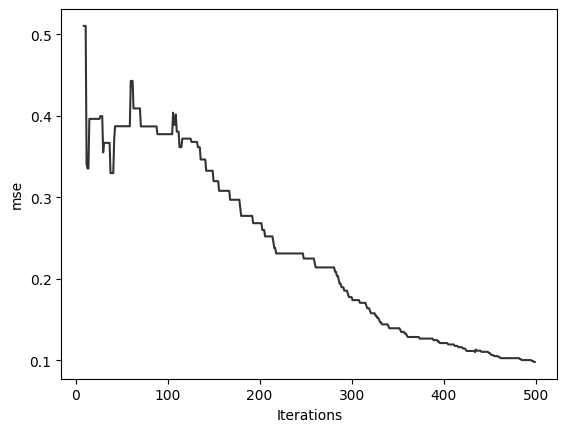

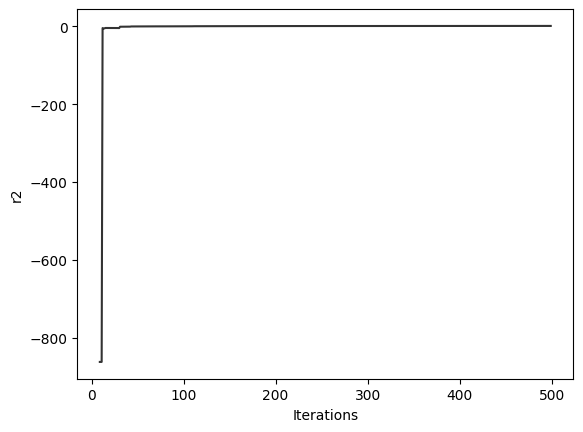

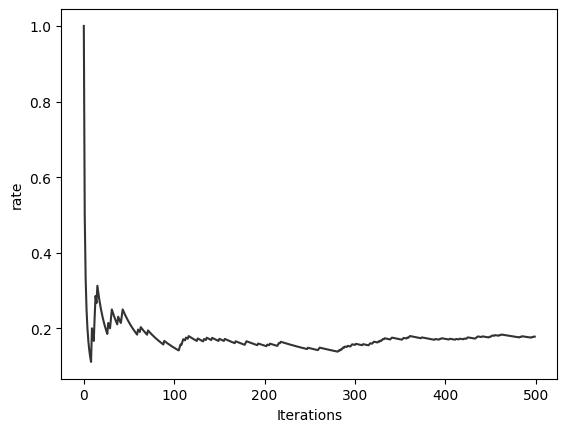

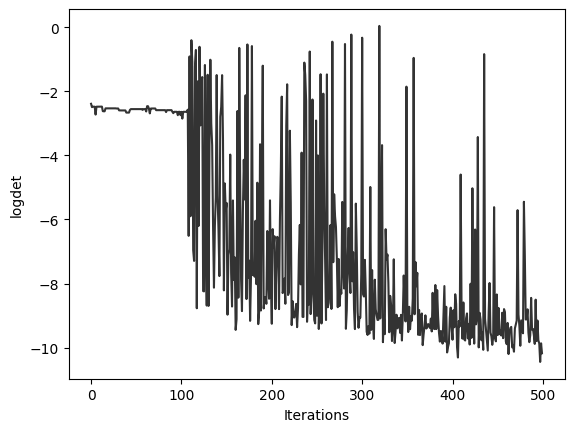

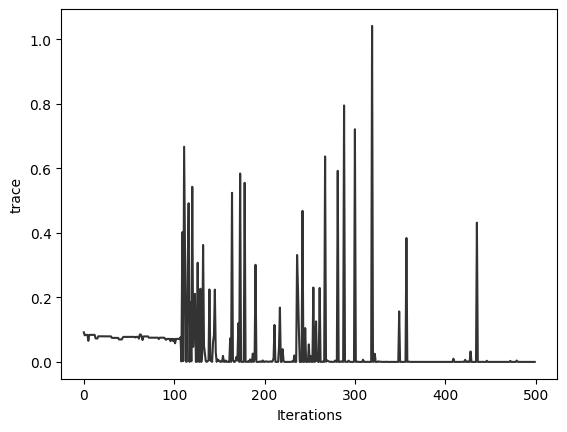

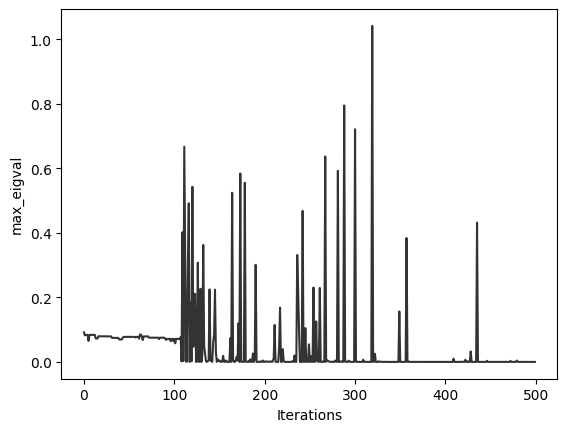

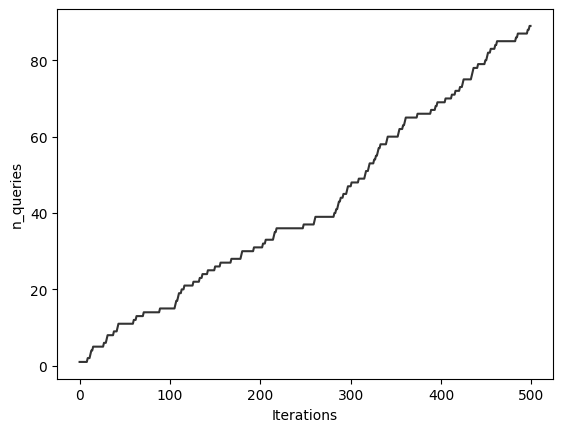

In [11]:
for k, v in learner.metrics.items():
    plt.plot(v, c='k', alpha=0.8)
    plt.xlabel('Iterations')
    plt.ylabel(k)
    plt.show()

Along with the above running statistics, we also have summary statistics available from the active learner object.
- **`mse_per_query`:**  
  This represents the mean squared error (MSE) per simulator query. A lower value indicates the emulator is closely matching the simulator’s output on average each time it's queried, suggesting good predictive performance.

- **`r2_per_query`:**  
  The coefficient of determination ($R^2$) per simulator query measures how well emulator predictions explain the variability in the simulator outputs. An $R^2$ value close to 0 suggests that emulator predictions are currently only slightly better than simply predicting the mean.

- **`trace_per_query`:**  
  This metric  is the trace of the emulator’s covariance matrix per query, reflecting the average uncertainty across the emulator’s predicted dimensions. A small value means that, on average, the emulator is very certain about its predictions at the time of querying.

- **`logdet_per_query`:**  
  The log determinant of the covariance per query quantifies the overall uncertainty volume in the emulator’s predictions. A negative and decreasing value typically indicates increased confidence and improved stability in emulator predictions.

- **`max_eigval_per_query`:**  
  The maximum eigenvalue of the covariance matrix per query indicates uncertainty along the dimension with the highest variance. A small value signifies that even in the direction of greatest uncertainty, predictions remain relatively confident.

- **`auc_mse`:**  
  The Area Under the Curve (AUC) of the cumulative mean squared error summarizes the emulator’s predictive error over the entire learning process. A lower AUC-MSE generally indicates better overall emulator performance across queries.

In [12]:
learner.summary

{'mse_per_query': 0.0010999890693118063,
 'r2_per_query': 0.008975192402186019,
 'trace_per_query': 4.286176702949438e-07,
 'logdet_per_query': -0.11431532227591182,
 'max_eigval_per_query': 4.286176702949438e-07,
 'auc_mse': 19.34059715270996}

## A full experiment with all stream-based Learners (advanced)

AutoEmulate includes a variety of **stream-based active learners**, each using a different strategy to decide whether to query the simulator.

### 1. `Random`

- **Strategy**: Queries the simulator at random.
- **Control**: Uses a fixed probability (`p_query`).
- **Use case**: Serves as a baseline for comparison.


### 2. Threshold-Based Learners

These learners query the simulator only when a particular metric exceeds a fixed threshold.

- **`Distance`**  
  Based on distance in the input space. Queries when a new input is sufficiently far from the training data.

- **`A_Optimal`**, **`D_Optimal`**, **`E_Optimal`**  
  Use information-theoretic metrics derived from the emulator:
  - **`A_Optimal`**: Minimizes the trace of the inverse Fisher information matrix.
  - **`D_Optimal`**: Maximizes the determinant (volume) of the Fisher information.
  - **`E_Optimal`**: Maximizes the smallest eigenvalue (worst-case direction).

> These methods use a **fixed threshold**, which may become suboptimal as the emulator's uncertainty naturally decreases over time.


### 3. Adaptive Threshold Learners (PID-Controlled)

To maintain a steady query rate over time, **adaptive learners** use a **PID controller** to adjust the threshold dynamically.

This turns active learning into a control problem where:

- The **threshold** is the control input.
- The **query rate** is the measured system output.
- The **target query rate** is the setpoint.

The PID controller updates the threshold as follows:
$$
u_k = K_p e_k + K_i \sum_{j=0}^k e_j + K_d (e_k - e_{k-1}), \quad \text{where} \quad e_k = \text{rate}_k - \text{rate}_\text{target}
$$

#### Adaptive Variants:
- **`Adaptive_Distance`**: Applies PID control to input-space diversity.
- **`Adaptive_A_Optimal`**: PID-controlled version of A-optimal design.
- **`Adaptive_D_Optimal`**: PID-controlled version of D-optimal design.
- **`Adaptive_E_Optimal`**: PID-controlled version of E-optimal design.

These learners maintain a desired number of simulator queries over time by continuously adapting their thresholds.


This suite of learners allows you to balance between:
- **Exploration** (via distance-based criteria),
- **Exploitation** (via uncertainty-based optimal design),
- And **control over query budget** (via adaptive strategies).


### Defining the Learners

To facilitate benchmarking, we define a `learners` function that returns a collection of stream-based active learning strategies. Each learner is initialized with:

- A **simulator** (e.g. `Sin`, `Projectile`)
- An **emulator** (a Gaussian Process in our case)
- An **initial training dataset** of input-output pairs

This function supports two modes:
- If `adaptive_only=False`, both **fixed-threshold** and **adaptive (PID-controlled)** learners are included.
- If `adaptive_only=True`, only the adaptive learners are returned.

The learners cover:
- Baseline: `Random`
- Threshold-based: `Distance`, `A_Optimal`, `D_Optimal`, `E_Optimal`
- Adaptive PID-controlled variants: `Adaptive_Distance`, `Adaptive_A_Optimal`, `Adaptive_D_Optimal`, `Adaptive_E_Optimal`

This modular setup allows us to easily loop over multiple learner types in the experiment and compare their performance on the same stream of inputs.


In [13]:
def learners(*, simulator: Simulator, n_initial_samples: int, adaptive_only: bool) -> Iterable:
    X_train = simulator.sample_inputs(n_initial_samples)
    Y_train = simulator.sample(X_train)
    yield stream.Random(
        simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
        X_train=X_train, Y_train=Y_train,
        p_query=0.25
    )
    if not adaptive_only:
        yield stream.Distance(
            simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
            X_train=X_train, Y_train=Y_train,
            threshold=0.5
        )
        yield stream.A_Optimal(
            simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
        yield stream.D_Optimal(
            simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
            X_train=X_train, Y_train=Y_train,
            threshold=-4.2
        )
        yield stream.E_Optimal(
            simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
    yield stream.Adaptive_Distance(
        simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
        X_train=X_train, Y_train=Y_train,
        threshold=0.5, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=2.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_A_Optimal(
        simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
        X_train=X_train, Y_train=Y_train,
        threshold=1e-1, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_D_Optimal(
        simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
        X_train=X_train, Y_train=Y_train,
        threshold=-4.0, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=-5 if isinstance(simulator, Sin) else None, 
        max_threshold=0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_E_Optimal(
        simulator=simulator, emulator=GaussianProcessExact(X_train, Y_train, **gp_config),
        X_train=X_train, Y_train=Y_train,
        threshold=0.75 if isinstance(simulator, Sin) else 1000, 
        Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )

### Running the Experiment

The `run_experiment` function evaluates each learner on a fixed stream of input points, over multiple random seeds. For each trial:

1. A stream of inputs is sampled from the simulator.
2. Each learner is initialized with the same initial dataset.
3. The learner processes the stream (either in batches or one sample at a time).
4. Key performance metrics and summary statistics are recorded.

This setup supports toggling:
- Number of **initial training samples**
- Number of **streamed inputs**
- Whether to include only **adaptive learners**
- Optional **batch size** for processing

The results include:
- `metrics`: detailed time-series metrics for each learner
- `summary`: overall performance summaries for final comparison


In [14]:
def run_experiment(
    *,
    simulator: Simulator,
    seeds: List[int],
    n_initial_samples: int,
    n_stream_samples: int,
    adaptive_only: bool,
    batch_size: int | None = None
) -> Tuple[List[Dict], List[Dict]]:
    metrics, summary = list(), list()
    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        X_stream = simulator.sample_inputs(n_stream_samples)
        tqdm.write(f"Trial with seed {seed}")
        for learner in learners(
            simulator=simulator, 
            n_initial_samples=n_initial_samples, 
            adaptive_only=adaptive_only
        ):
            if batch_size is not None:
                learner.fit_batches(X_stream, batch_size)
            else:
                learner.fit_samples(X_stream)
            metrics.append(dict(
                name=learner.__class__.__name__,
                **learner.metrics
            ))
            summary.append(dict(
                name=learner.__class__.__name__,
                **learner.summary
            ))
    return metrics, summary

### Summarizing Results

After all learners have been evaluated, we use the `compute_statistics` function to produce a compact summary of performance across trials.

```python
compute_statistics(summary: List[Dict]) -> pd.DataFrame


In [15]:
def compute_statistics(summary: List[Dict]) -> pd.DataFrame:
    df = pd.DataFrame(summary).groupby('name').agg(['mean', 'std'])
    df = df.sort_values(('mse_per_query', 'mean'), ascending=True).round(6)
    return df

### Visualizing Performance

To better understand how learners perform over time, we use the `plot_metrics`.

In [16]:
def plot_metrics(metrics: List[Dict], smoothing_window=10):

    # Compute the mean and variance curves for each class
    def mean(s): return np.vstack(s).mean(axis=0).tolist()
    def std(s):  return np.vstack(s).std(axis=0).tolist()
    df = pd.DataFrame(metrics).groupby("name").agg([mean, std])

    # Smoothing to help visualisation
    def moving_average(data, window):
        pad_width = window // 2
        padded_data = np.pad(data, (pad_width, window - pad_width - 1), mode='edge')
        return np.convolve(padded_data, np.ones(window)/window, mode='valid')
    
    # Plot each metric
    for metric in df.columns.get_level_values(0).unique():
        for learner in df.index:
            mean_values = moving_average(np.array(df.loc[learner, (metric, "mean")]), window=smoothing_window)
            std_values  = moving_average(np.array(df.loc[learner, (metric, "std")]), window=smoothing_window)
            iterations = np.arange(len(mean_values))
            plt.plot(iterations, mean_values, label=learner if len(mean_values) != 1 else None)
            plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, alpha=0.2)
        if metric == 'r2':
            plt.ylim(-1, 1)
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Active learning with the Sinusoid simulation

In [17]:
metrics, summary = run_experiment(
    simulator=Sin(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [00:14<00:00, 34.20it/s, mse=0.115, r2=0.773, rate=0.256, logdet=-10.1, trace=4.2e-5, max_eigval=4.2e-5, n_queries=128, score=4.2e-5, threshold=0, error_prop=0.00451, error_int=-0.023, error_deriv=0.0015]               


Trial with seed 1


Adaptive_E_Optimal: 100%|██████████| 500/500 [00:10<00:00, 48.55it/s, mse=0.0669, r2=0.869, rate=0.25, logdet=-9.7, trace=6.1e-5, max_eigval=6.1e-5, n_queries=125, score=6.1e-5, threshold=0, error_prop=-0.0015, error_int=-0.0714, error_deriv=0.00151]               


In [18]:
compute_statistics(summary)

mse_per_query           r2_per_query            \
                            mean       std         mean       std   
name                                                                
Adaptive_Distance       0.000559  0.000063     0.007235  0.000176   
Adaptive_A_Optimal      0.000629  0.000312     0.006646  0.000807   
Random                  0.000678  0.000108     0.006953  0.000108   
Adaptive_E_Optimal      0.000718  0.000257     0.006495  0.000642   
Adaptive_D_Optimal      0.011193  0.002630     0.007553  0.008419   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_Distance         0.000000  0.000000        -0.085340  0.000073   
Adaptive_A_Optimal        0.000000  0.000000        -0.081426  0.002404   
Random                    0.000000  0.000000        -0.083067  0.000083   
Adaptive_E_Optimal        0.000000  0.000000        -0.078186  0.000783   
Adaptive_D_Optimal        0.000063  0.000076        -0.226903  0.064290   

                   max_eigval_per_query              auc_mse             
                                   mean       std       mean        std  
name                                                                     
Adaptive_Distance              0.000000  0.000000  21.232103   1.074722  
Adaptive_A_Optimal             0.000000  0.000000  25.153875  11.204294  
Random                         0.000000  0.000000  24.780220   2.961457  
Adaptive_E_Optimal             0.000000  0.000000  28.289063  10.238486  
Adaptive_D_Optimal             0.000063  0.000076  10.846203   0.933348

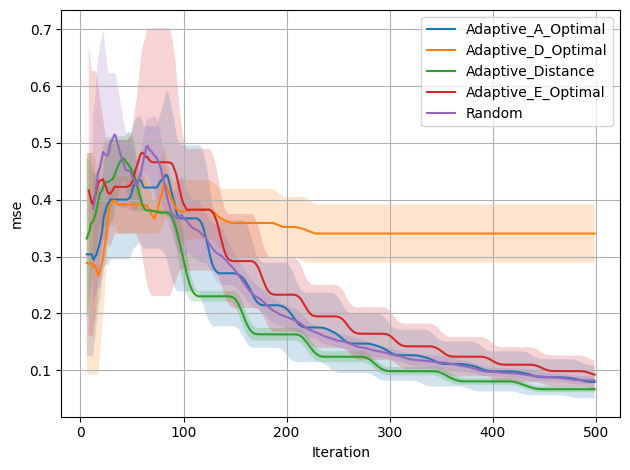

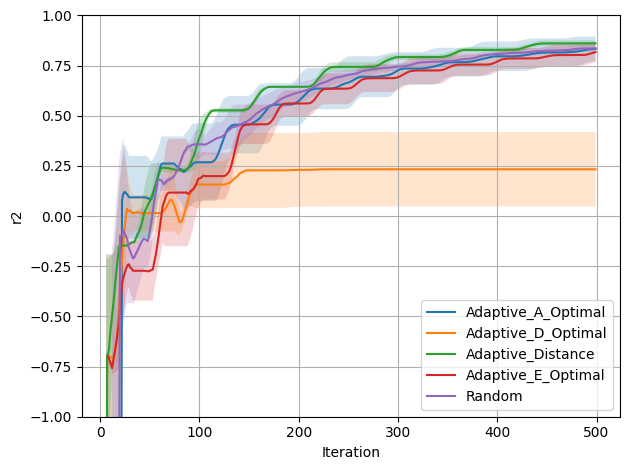

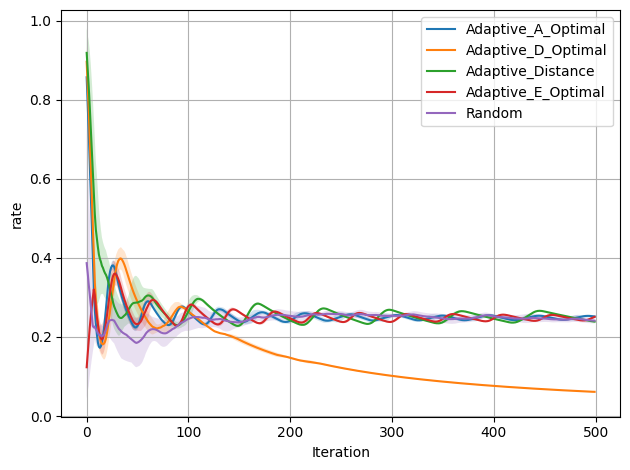

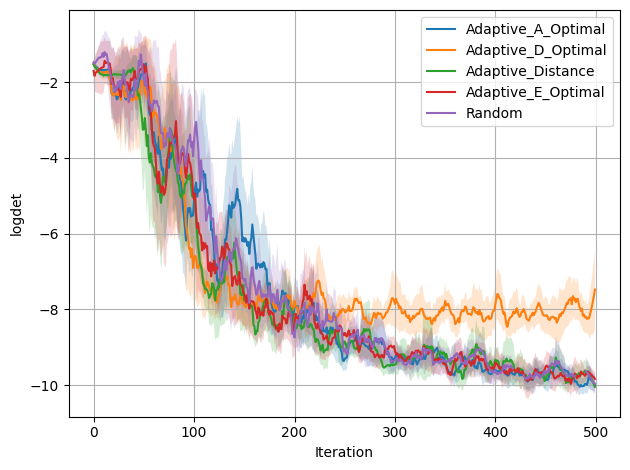

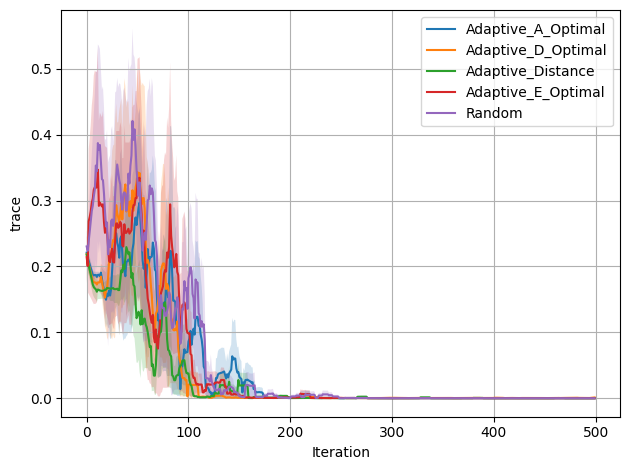

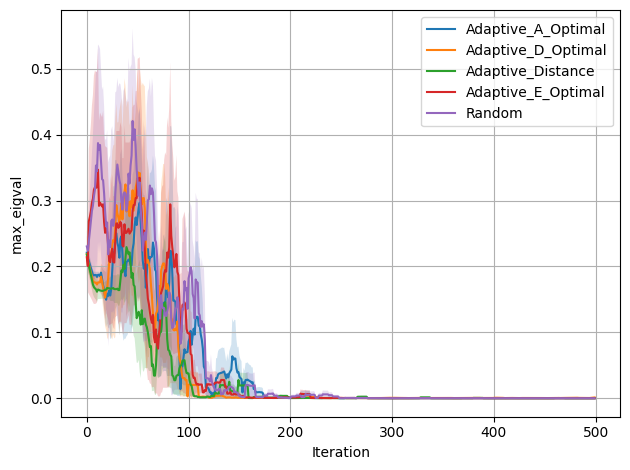

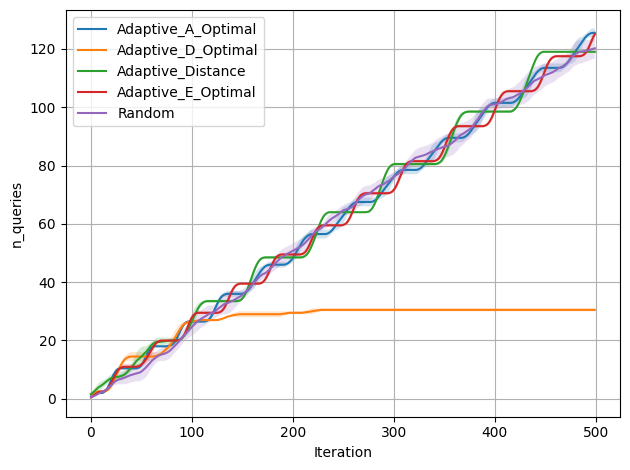

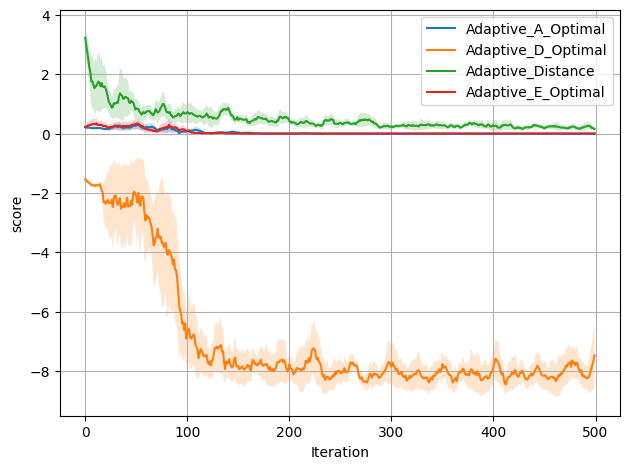

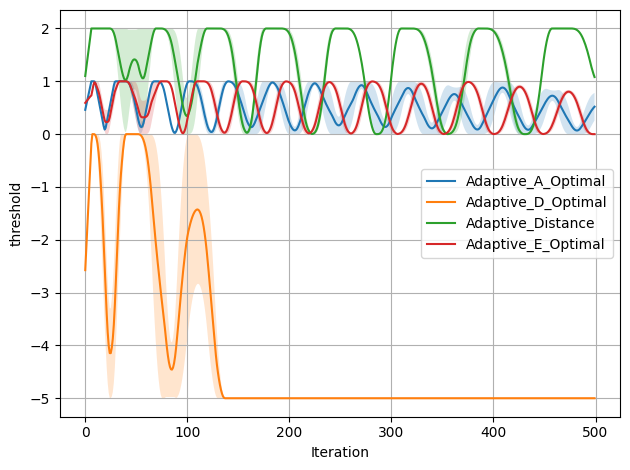

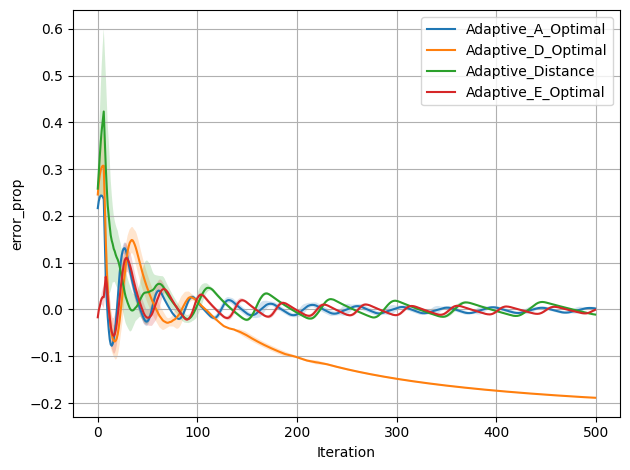

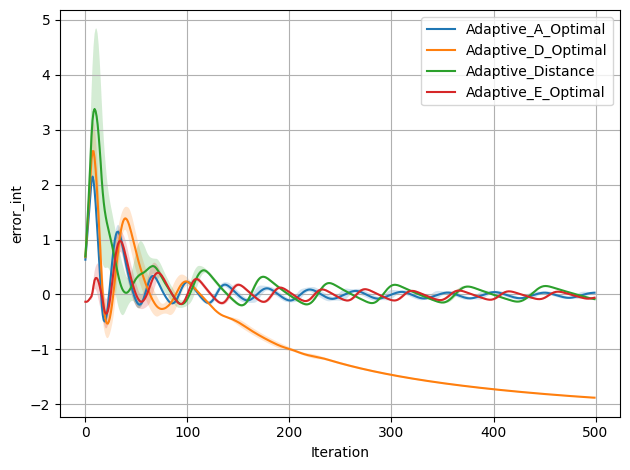

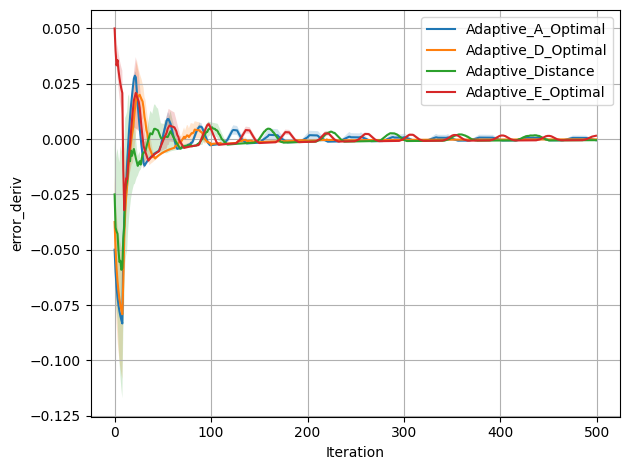

In [19]:
plot_metrics(metrics)

As we can see:
1. The query rate approaches 0.25, as expected.
2. The MSE approaches 0.
3. The R2 score approache 1.
4. The covariance matrix max eigenvalue and trace appraoch 0, and the log determinant approaches around -4.2.
5. The number of queries and PID gains stabalise.

### Active learning with the Projectile simulation

Here we do the same thing, but for the more difficult projectile example.

In [ ]:
# TODO: fix error: RuntimeError: Expected b and A to have the same dtype, but found b of type Double and A of type Float instead.
metrics, summary = run_experiment(
    simulator=Projectile(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

In [ ]:
compute_statistics(summary)

In [ ]:
plot_metrics(metrics)